In [1]:
import pandas as pd
import numpy as np
import random
import torch
import time
import sys
import re
import os

!pip install demoji
import demoji
demoji.download_codes()

!pip install greek-stemmer-pos
from greek_stemmer import stemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import  cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel

import warnings
warnings.filterwarnings('ignore')

!pip install torchmetrics
!pip install transformers

# torch
import torch
import torch.cuda
import torch.nn as nn
import torch.backends.cudnn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

from torchmetrics import ConfusionMatrix
from torchmetrics.functional import f1_score

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.4 MB/s eta 0:00:00


/tmp/ipykernel_27/394593571.py:12: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 3.6 MB/s eta 0:00:00
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## Read Files & Extract Information

In [2]:
# paths
TrainSet_File = '/kaggle/input/ys19-2023-assignment-4a/train_set.csv'
ValidSet_File = '/kaggle/input/ys19-2023-assignment-4a/valid_set.csv'
TestSet_File = '/kaggle/input/ys19-2023-assignment-4a/test_set.csv'
GreekStopWords_File = '/kaggle/input/greekstopwords-ass4/stopwords-el.csv'

# read files (train, validation and test set) and save them in dataframes
dataframe_TrainSet = pd.read_csv(TrainSet_File, sep=',')
dataframe_ValidSet = pd.read_csv(ValidSet_File, sep=',')
dataframe_TestSet = pd.read_csv(TestSet_File, sep=',')

# read GreekStopWords_File and save this in dataframe
dataframe_GreekStopWords = pd.read_csv(GreekStopWords_File, sep=' ')
GreekStopWordsList =  list(dataframe_GreekStopWords["string"])
#GreekStopWordsList

$ $

$ \bullet $  $ $ $ $ Training Set

In [3]:
dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είνα...,NEUTRAL,SYRIZA


$ $

$ \bullet $  $ $ $ $ Validation Set

In [4]:
dataframe_ValidSet.head()

,New_ID,Text,Sentiment,Party
0,435,@GLinard @teza_tereza @AdonisGeorgiadi @atsipr...,POSITIVE,SYRIZA
1,3061,Τσίπρας: Ζητήσαμε και από την αντιπολίτευση να...,NEGATIVE,SYRIZA
2,2161,"Ο σωστος ο Ελληνας, ο δημοκρατης, ο Ελληνας το...",NEGATIVE,ND
3,1271,@30__kai Ναι βλέπεις αυτά ενδιαφέρουν τους Μητ...,POSITIVE,ND
4,4396,Η συνέντευξη Μητσοτάκη στον Alpha: Υπό αίρεση ...,NEUTRAL,ND


$ $

$ \bullet $  $ $ $ $ Test Set

In [5]:
dataframe_TestSet.head()

,New_ID,Text,Party
0,1,Ο Κυριάκος Μητσοτάκης δεν ξέρει που είναι το Μ...,ND
1,2,Συνέντευξη της υποψήφιας βουλευτή με τη Νέα Δη...,ND
2,3,Σε αυτές τις εκλογές οι μαθητές και οι φοιτητέ...,KKE
3,4,Γεννηματά: Το ΚΙΝΑΛ δεν θα γίνει δεκανίκι κανε...,PASOK
4,5,"Την Κυριακή των εκλογών, Οκτώβρης 1993, ξημερώ...",ND


## Data processing and Analysis

####  Pre-processing

##### **1**. $ $  **Data Cleaning**

$ \bullet$ $ $ Auxiliary functions for Data Cleaning

In [6]:
# 1. Remove URLs
def remove_URLS(ww):
    w1 = ""

    word_list = ww.split()
    for word in word_list:
        if len(word) > 8:
            auxilary_str = word[:8]
            if auxilary_str == "https://":
                continue

        w1 += word
        w1 += " "

    return w1


# 2. Remove Hashtags
def remove_Hashtags(ww):
    w1 = ""
    
    word_list = ww.split()
    for word in word_list:
        auxilary_str = word[:1]
        if auxilary_str == "#":
            continue
        else:
            w1 += word
            w1 += " "

    return w1


# 3. Remove Tags
def remove_Tags(ww):
    w1 = ""

    word_list = ww.split()
    for word in word_list:
        auxilary_str = word[:1]
        if auxilary_str == "@":
            continue
        else:
            w1 += word
            w1 += " "

    return w1


# 4. Remove Symbols
def remove_symbols(ww):

    w1 = ""

    for c in ww:

        if c in ['+', '-', ':', '(', ')', '[', ']', '{', '}', '!',
                 '?', '$', '%', '^', '&', '*', '~', '\;', '«', '»',
                 '.', '`', '=', '#', '@', ']', '|', '‘', '、', ',',
                 '。', '”', '\'', '"']:
            w1 += ' '
        elif c == '_':
            w1 += ' '
        else:
            w1 += c

    return w1


# 5. Remove Emojis
def remove_emoji(ww):
    emoji_list = demoji.findall(ww)
    for emoji in emoji_list:
        ww = re.sub(emoji, ' ', ww)

    return ww

# 6. Remove Numbers
def remove_numbers(string):
    string = re.sub(r"\d+",' ' , string)
    return string


$\bullet $  $  $  Data Cleaning

In [7]:
def data_cleaning(text):

    text = remove_URLS(text)
    text = remove_Hashtags(text)
    text = remove_Tags(text)
    text = remove_symbols(text)
    text = remove_emoji(text)
    text = remove_numbers(text)
    
    return text

dataframe_TrainSet['Text'] = dataframe_TrainSet.apply(lambda row: data_cleaning(row['Text']), axis=1)
dataframe_ValidSet['Text'] = dataframe_ValidSet.apply(lambda row: data_cleaning(row['Text']), axis=1)
dataframe_TestSet['Text'] = dataframe_TestSet.apply(lambda row: data_cleaning(row['Text']), axis=1)

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,Κυριακη Κοριοί απολύμανση Καταπολέμηση κοριώ...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία καίνε τη...,NEGATIVE,ND
2,14146,Ισχυρό ΚΚΕ δύναμη του λαού στη Βουλή και στου...,POSITIVE,KKE
3,28716,Μνημονιακότατο το,NEUTRAL,KKE
4,32886,Αυτό που είναι συγκλονιστικό είναι η ψυχασθένε...,NEUTRAL,SYRIZA


##### **2**. $ $ **Simplification**

In [8]:
# convert all the letters to lowercase
def lowercase(string):
    string2 = string.lower()
    return string2

dataframe_TrainSet['Text'] = dataframe_TrainSet.apply(lambda row: lowercase(row['Text']), axis=1)
dataframe_ValidSet['Text'] = dataframe_ValidSet.apply(lambda row: lowercase(row['Text']), axis=1)
dataframe_TestSet['Text'] = dataframe_TestSet.apply(lambda row: lowercase(row['Text']), axis=1)

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,κυριακη κοριοί απολύμανση καταπολέμηση κοριώ...,NEUTRAL,SYRIZA
1,9531,έξι νέες επιστολές για τη μακεδονία καίνε τη...,NEGATIVE,ND
2,14146,ισχυρό κκε δύναμη του λαού στη βουλή και στου...,POSITIVE,KKE
3,28716,μνημονιακότατο το,NEUTRAL,KKE
4,32886,αυτό που είναι συγκλονιστικό είναι η ψυχασθένε...,NEUTRAL,SYRIZA


$ $

##### **3**. $ $ **StopWords**

In [9]:
# remove stop words
dataframe_TrainSet['Text'] = dataframe_TrainSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (GreekStopWordsList)]))
dataframe_ValidSet['Text'] = dataframe_ValidSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (GreekStopWordsList)]))
dataframe_TestSet['Text'] = dataframe_TestSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (GreekStopWordsList)]))

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,κυριακη κοριοί απολύμανση καταπολέμηση κοριών ...,NEUTRAL,SYRIZA
1,9531,έξι νέες επιστολές μακεδονία καίνε νδ μητσοτάκ...,NEGATIVE,ND
2,14146,ισχυρό κκε δύναμη λαού βουλή καθημερινούς αγώνες,POSITIVE,KKE
3,28716,μνημονιακότατο,NEUTRAL,KKE
4,32886,αυτό είναι συγκλονιστικό είναι ψυχασθένεια τσίπρα,NEUTRAL,SYRIZA


In [10]:
def has_greek_letters(ww):
    words_with_greek_letters = []
    word_list = ww.split()
    
    for word in word_list:
        if bool(re.match('[α-ωΑ-Ω]+$', word)):
            words_with_greek_letters.append(word)
    
    return ' '.join(words_with_greek_letters)

dataframe_TrainSet['Text'] = dataframe_TrainSet['Text'].apply(has_greek_letters)
dataframe_ValidSet['Text'] = dataframe_ValidSet['Text'].apply(has_greek_letters)
dataframe_TestSet['Text'] = dataframe_TestSet['Text'].apply(has_greek_letters)

dataframe_TrainSet

,New_ID,Text,Sentiment,Party
0,35027,κυριακη,NEUTRAL,SYRIZA
1,9531,νδ,NEGATIVE,ND
2,14146,κκε,POSITIVE,KKE
3,28716,,NEUTRAL,KKE
4,32886,,NEUTRAL,SYRIZA
...,...,...,...,...
36625,35374,,NEUTRAL,ND
36626,7744,,NEGATIVE,ND
36627,35216,κκε,NEUTRAL,KKE
36628,2855,μαρη ναζιστη τρολ νδ λιποθυμησεις ναζιστες,NEGATIVE,ND


#### Analysis

In [11]:
# merge the train, valid and test set into a dataframe
dataframe = pd.concat([dataframe_TrainSet, dataframe_ValidSet, dataframe_TestSet])

$\bullet$ $ $  Word Cloud

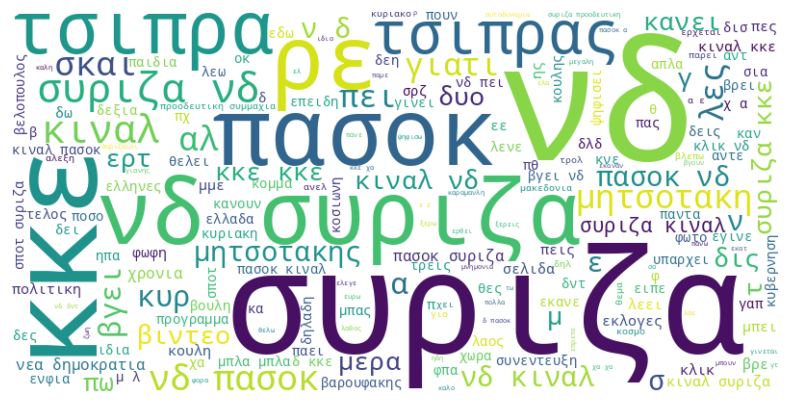

In [12]:
def Word_Cloud(data):
   
    words_list = []
    
    # divide each line into words and store them in a list
    for text in data:
        words = text.split()
        words_list.extend(words)
    
    # connect the words in a text with each other
    String_allWords = ' '.join(words_list)
    
    # create WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(String_allWords)
    
    # visualization
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
        

Word_Cloud(dataframe['Text'])

$\bullet$ $ $ Find the occurrences of each word

In [13]:
# Calculate the occurrences of each word.
bow_vectorizer = CountVectorizer()
bow_xtrain = bow_vectorizer.fit_transform(dataframe_TrainSet['Text'])
b = bow_xtrain.toarray()
k = np.sum(b, axis=0)  

feature_genres = bow_vectorizer.get_feature_names_out()

# Create a dictionary with the name of the genres and the number of their occurrences.
genre_appear = dict(zip(feature_genres, k))

# Sort the dictionary in descending order based on the number of appearances of the species.
sortedDict = dict(sorted(genre_appear.items(), key=lambda item: item[1]))
sortDescOrder = dict(reversed(list(sortedDict.items())))
sortDescOrder

{'νδ': 5541,
 'συριζα': 4334,
 'κκε': 2688,
 'πασοκ': 1930,
 'κιναλ': 1704,
 'ρε': 897,
 'τσιπρας': 763,
 'τσιπρα': 707,
 'σκαι': 532,
 'αλ': 450,
 'μητσοτακη': 440,
 'πει': 401,
 'λες': 388,
 'βγει': 384,
 'γιατι': 352,
 'κυρ': 314,
 'μητσοτακης': 298,
 'χα': 261,
 'δις': 252,
 'βιντεο': 248,
 'κλικ': 240,
 'νεα': 239,
 'μερα': 239,
 'δημοκρατια': 238,
 'ερτ': 234,
 'σποτ': 226,
 'πω': 213,
 'δυο': 206,
 'κανει': 194,
 'εκλογες': 186,
 'φωτο': 179,
 'χρονια': 176,
 'ελλαδα': 176,
 'μπει': 163,
 'λεει': 161,
 'φωφη': 152,
 'πες': 149,
 'βρε': 149,
 'σελιδα': 145,
 'εε': 141,
 'μμε': 139,
 'πολιτικη': 132,
 'πεις': 132,
 'κουλη': 130,
 'εδω': 130,
 'δω': 127,
 'μπλα': 125,
 'ης': 125,
 'δντ': 125,
 'κουλης': 123,
 'κυβερνηση': 111,
 'ωρα': 110,
 'δεη': 110,
 'παει': 109,
 'καν': 109,
 'δει': 108,
 'πας': 107,
 'πθ': 106,
 'εκανε': 106,
 'κομμα': 105,
 'θες': 105,
 'ελληνες': 105,
 'χωρα': 102,
 'δισ': 100,
 'συνεντευξη': 97,
 'θελει': 97,
 'ποσο': 96,
 'αντ': 94,
 'λαος': 92,
 'παιδια':

$\bullet$ $ $ Find the occurrences of each sentiment **Train & Valid set**

In [14]:
# merge the train and valid set into a dataframe
dataframeTV = pd.concat([dataframe_TrainSet, dataframe_ValidSet])

bow_vectorizer = CountVectorizer(lowercase=False)
bow_xtrain = bow_vectorizer.fit_transform(dataframeTV['Sentiment'])
b = bow_xtrain.toarray()
k = np.sum(b, axis=0)

feature_genres = bow_vectorizer.get_feature_names_out()

# Create a dictionary with the name of the genres and the number of their occurrences.
genre_appear = dict(zip(feature_genres, k))

print(genre_appear)

{'NEGATIVE': 13954, 'NEUTRAL': 13954, 'POSITIVE': 13954}


#### Data conversion to vectors

In [15]:
tokenizer1 = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
tokenizer2 = AutoTokenizer.from_pretrained("EftychiaKarav/DistilGREEK-BERT")

def Vectorize(dataset, tokenizer):
    # Tokenize all of the sentences and map the tokens to their word IDs.
    input_ids = []
    attention_masks = []

    for text in dataset["Text"]:
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                            max_length=64,           # Pad & truncate all sentences.
                            pad_to_max_length=True,
                            return_attention_mask=True,   # Construct attn. masks.
                            return_tensors='pt',      # Return PyTorch tensors.
                            truncation=True           # Explicitly activate truncation
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # Add its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## BERT Model Creation

#### GreekBERT model

In [16]:
from torch.utils.data import TensorDataset

# convert labels to numerical values
labelencoder = LabelEncoder()

# train set
Y_train = labelencoder.fit_transform(dataframe_TrainSet['Sentiment'])
labels_train = torch.tensor(Y_train)
input_ids_train, attention_masks_train = Vectorize(dataframe_TrainSet, tokenizer1)
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)


# valid set
Y_val = labelencoder.fit_transform(dataframe_ValidSet['Sentiment'])
labels_val = torch.tensor(Y_val)
input_ids_val, attention_masks_val = Vectorize(dataframe_ValidSet, tokenizer1)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# test set
input_ids_test, attention_masks_test = Vectorize(dataframe_TestSet, tokenizer1)
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset),batch_size = batch_size)

prediction_dataloader = DataLoader(test_dataset, sampler=RandomSampler(test_dataset), batch_size=batch_size)

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model1 = BertForSequenceClassification.from_pretrained("nlpaueb/bert-base-greek-uncased-v1",
                                                       num_labels = 3, # The number of output labels--2 for binary classification.
                                                       output_attentions = False, # Whether the model returns attentions weights.
                                                       output_hidden_states = False, # Whether the model returns all hidden-states.
                                                      )   
model1.to(device)  # Move the model to the GPU

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

**Definition of the training and testing process**

In [19]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [21]:
def network_training(model, train_dataloader, scheduler, optimizer, t0):

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
            
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss 

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            

    return model, avg_train_loss

In [22]:
def test_loop(model, validation_dataloader):
    
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels)

            loss = outputs.loss
            logits = outputs.logits 

        
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    return avg_val_accuracy, avg_val_loss

In [23]:
from transformers import get_linear_schedule_with_warmup

def TrainingEvalutionLoops(model, train_dataloader, validation_dataloader):
    
    best_f1 = 0.0
    best_epoch = 0
    best_model = model
    best_lr = None
    best_eps = None

    for learning_rate in [1e-5, 1e-4, 1e-3]:
        
        for epsilon in [1e-8, 1e-7, 1e-6]:
            
            print(f"-learning_rate: {learning_rate}\n-epsilon: {epsilon}\n")
            
            optimizer = AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

            epochs = 3

            # Total number of training steps is [number of batches] x [number of epochs]. 
            # (Note that this is not the same as the number of training samples).
            total_steps = len(train_dataloader) * epochs

            # Create the learning rate scheduler.
            scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                        num_warmup_steps = 0, # Default value in run_glue.py
                                                        num_training_steps = total_steps)

            # Set the seed value all over the place to make this reproducible.
            seed_val = 42

            random.seed(seed_val)
            np.random.seed(seed_val)
            torch.manual_seed(seed_val)
            torch.cuda.manual_seed_all(seed_val)

            # We'll store a number of quantities such as training and validation loss, 
            # validation accuracy, and timings.
            training_stats = []

            # Measure the total training time for the whole run.
            total_t0 = time.time()

            # For each epoch...
            for epoch_i in range(0, epochs):

                print("")
                print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
                print('Training...')
                    
                # ========================================
                #               Training
                # ========================================
                    
                t0 = time.time()
                    
                model, avg_train_loss = network_training(best_model, train_dataloader, scheduler, optimizer, t0) 

                # Measure how long this epoch took.
                training_time = format_time(time.time() - t0)

                print("")
                print("  Average training loss: {0:.2f}".format(avg_train_loss))
                print("  Training epcoh took: {:}".format(training_time))
                    
                   
                # ========================================
                #               Validation
                # ========================================
                # After the completion of each training epoch, measure our performance on
                # our validation set.

                print("")
                print("Running Validation...")

                t0 = time.time()

                avg_val_accuracy, avg_val_loss = test_loop(model, validation_dataloader)

                # Measure how long the validation run took.
                validation_time = format_time(time.time() - t0)

                print("  Validation Loss: {0:.2f}".format(avg_val_loss))
                print("  Validation took: {:}".format(validation_time))

                # Record all statistics from this epoch.
                training_stats.append(
                    {
                        'epoch': epoch_i + 1,
                        'Training Loss': avg_train_loss,
                        'Valid. Loss': avg_val_loss,
                        'Valid. Accur.': avg_val_accuracy,
                        'Training Time': training_time,
                        'Validation Time': validation_time
                    }
                )

                if avg_val_accuracy >= best_f1:
                    best_f1 = avg_val_accuracy
                    best_model = model
                    best_lr = learning_rate
                    best_eps = epsilon
                    best_epoch = epoch_i

            print("")
            print("Training complete!")

            print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
                
    return best_f1, best_lr, best_eps, best_epoch, best_model

In [24]:
# model 1: GreekBERT
best_f1_1, best_lr1, best_eps1, best_epoch1, best_model1 = TrainingEvalutionLoops(model1, train_dataloader, validation_dataloader)
print(f"best_f1: {best_f1_1}, best_lr:{best_lr1}, best_eps:{best_eps1}, best_epoch:{best_epoch1}")

-learning_rate: 1e-05
-epsilon: 1e-08


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  1,145.    Elapsed: 0:00:08.
  Batch    80  of  1,145.    Elapsed: 0:00:16.
  Batch   120  of  1,145.    Elapsed: 0:00:24.
  Batch   160  of  1,145.    Elapsed: 0:00:31.
  Batch   200  of  1,145.    Elapsed: 0:00:39.
  Batch   240  of  1,145.    Elapsed: 0:00:47.
  Batch   280  of  1,145.    Elapsed: 0:00:54.
  Batch   320  of  1,145.    Elapsed: 0:01:02.
  Batch   360  of  1,145.    Elapsed: 0:01:10.
  Batch   400  of  1,145.    Elapsed: 0:01:17.
  Batch   440  of  1,145.    Elapsed: 0:01:25.
  Batch   480  of  1,145.    Elapsed: 0:01:32.
  Batch   520  of  1,145.    Elapsed: 0:01:40.
  Batch   560  of  1,145.    Elapsed: 0:01:48.
  Batch   600  of  1,145.    Elapsed: 0:01:55.
  Batch   640  of  1,145.    Elapsed: 0:02:03.
  Batch   680  of  1,145.    Elapsed: 0:02:11.
  Batch   720  of  1,145.    Elapsed: 0:02:18.
  Batch   760  of  1,145.    Elapsed: 0:02:26.
  Batch   800  of  1,145.


The best performance of the f1-score metric for validation set is 0.3668064024390244 at epoch no.2 with best_lr:1e-05, best_eps:1e-07 


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,145.    Elapsed: 0:00:08.
  Batch    80  of  1,145.    Elapsed: 0:00:15.
  Batch   120  of  1,145.    Elapsed: 0:00:23.
  Batch   160  of  1,145.    Elapsed: 0:00:30.
  Batch   200  of  1,145.    Elapsed: 0:00:38.
  Batch   240  of  1,145.    Elapsed: 0:00:46.
  Batch   280  of  1,145.    Elapsed: 0:00:53.
  Batch   320  of  1,145.    Elapsed: 0:01:01.
  Batch   360  of  1,145.    Elapsed: 0:01:09.
  Batch   400  of  1,145.    Elapsed: 0:01:16.
  Batch   440  of  1,145.    Elapsed: 0:01:24.
  Batch   480  of  1,145.    Elapsed: 0:01:31.
  Batch   520  of  1,145.    Elapsed: 0:01:39.
  Batch   560  of  1,145.    Elapsed: 0:01:47.
  Batch   600  of  1,145.    Elapsed: 0:01:54.
  Batch   640  of  1,145.    Elapsed: 0:02:02.
  Batch   680  of  1,145.    Elapsed: 0:02:10.
  Batch   720  of  1,

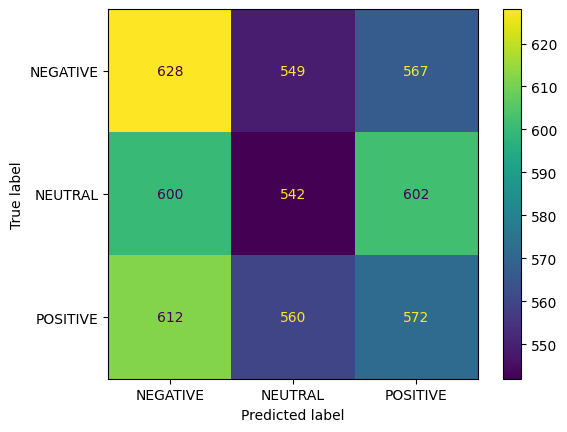

In [25]:
print(f"\nThe best performance of the f1-score metric for validation set is {best_f1_1} at epoch no.{best_epoch1} with best_lr:{best_lr1}, best_eps:{best_eps1} \n")

def ConfusionMatrix(model, lr, eps, best_epoch):
    
    model.eval()

    y_pred = []

    optimizer = AdamW(model.parameters(), lr = lr, eps = eps)

    epochs = best_epoch

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)

    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    training_stats = []

    total_t0 = time.time()


    for epoch_i in range(0, epochs):
        y_pred = []
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        model, avg_train_loss = network_training(model, train_dataloader, scheduler, optimizer, t0) 

        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to('cpu').numpy()

            with torch.no_grad():
                outputs = model1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                logits = outputs.logits
                predictions = np.argmax(logits.to('cpu').numpy(), axis=1)

            y_pred.extend(predictions)

    Y_val = labelencoder.fit_transform(dataframe_ValidSet['Sentiment'])
    print(classification_report(Y_val, y_pred))

    cm = metrics.confusion_matrix(Y_val, y_pred)
    labels = list(genre_appear.keys())
    cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()
    

ConfusionMatrix(best_model1, best_lr1, best_eps1, best_epoch1)

Training Loss: 1.10703328796055
Validation Loss: 1.0986883560331857
Training Loss: 1.1074715852737427
Validation Loss: 1.098855222143778
Training Loss: 1.1078269651462866
Validation Loss: 1.0986757889026548
Training Loss: 1.1082302102876023
Validation Loss: 1.0986525670784275
Training Loss: 1.1067741225111132
Validation Loss: 1.0986586772814029
Training Loss: 1.1072159176136556
Validation Loss: 1.0986718012065422
Training Loss: 1.106174098434591
Validation Loss: 1.0986511961715977
Training Loss: 1.1068409336446154
Validation Loss: 1.0986646871741226
Training Loss: 1.1075425344572614
Validation Loss: 1.098623035884485
Training Loss: 1.1062577785883407
Validation Loss: 1.0986357592954867


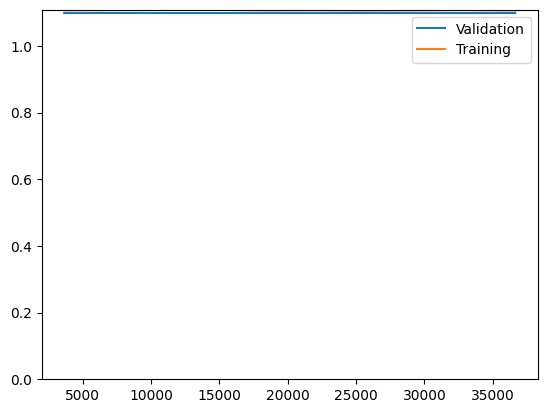

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import numpy as np
import torch
import time

def plot_learning_curves(model, tokenizer, train_set, val_set, device, lr, eps, clip, epochs=1, batch_size=32):
    
    train_scores = []
    val_scores = []
    sample_sizes = []

    total_size = len(train_set)
    increment = total_size // 10  
    
    for times in range(1, 11):
        sample_size = increment * times
        sample_sizes.append(sample_size)
        # Προετοιμασία των δειγμάτων
        current_train_set = torch.utils.data.Subset(train_set, list(range(sample_size)))
        train_dataloader = DataLoader(current_train_set, sampler=RandomSampler(current_train_set), batch_size=batch_size)
        val_dataloader = DataLoader(val_set, sampler=SequentialSampler(val_set), batch_size=batch_size)

        optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        for epoch in range(epochs):
            model.train()
            total_train_loss = 0
            for step, batch in enumerate(train_dataloader):
                batch = [r.to(device) for r in batch]
                b_input_ids, b_input_mask, b_labels = batch
                model.zero_grad()
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                total_train_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                scheduler.step()
                
            avg_train_loss = total_train_loss / len(train_dataloader)
            print(f"Training Loss: {avg_train_loss}")

            model.eval()
            total_eval_accuracy = 0
            total_eval_loss = 0
            for batch in val_dataloader:
                batch = [t.to(device) for t in batch]
                b_input_ids, b_input_mask, b_labels = batch
                with torch.no_grad():
                    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
                
                loss = outputs.loss
                total_eval_loss += loss.item()
                logits = outputs.logits
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
                total_eval_accuracy += flat_accuracy(logits, label_ids)
            
            avg_val_loss = total_eval_loss / len(val_dataloader)
            avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
            print(f"Validation Loss: {avg_val_loss}")

            train_scores.append(avg_train_loss)  
            val_scores.append(avg_val_loss)  

    plt.plot(sample_sizes, val_scores)
    plt.plot(sample_sizes, train_scores)
    
    plt.ylim(ymin=0)
    plt.legend(["Validation", "Training"])
    plt.show()

plot_learning_curves(model=model1, 
                     tokenizer=tokenizer1, 
                     train_set=train_dataset, 
                     val_set=val_dataset, 
                     device=device,  
                     lr=best_lr1, 
                     eps=best_eps1,
                     clip=1)

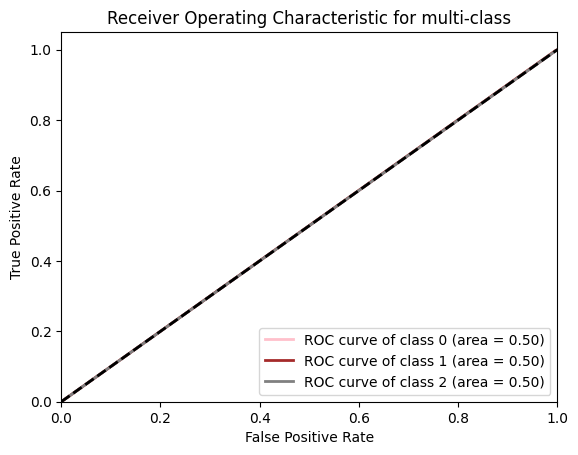

In [27]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

def plot_roc_curves(model, dataloader, device, num_classes):
    model.eval()
    true_labels = []
    predicted_prob = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1).cpu().numpy()
            
            true_labels.extend(b_labels.cpu().numpy())
            predicted_prob.extend(probabilities)

    true_labels = np.array(true_labels)
    predicted_prob = np.array(predicted_prob)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_prob[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['pink', 'brown', 'grey'])

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for multi-class')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curves(model1, validation_dataloader, device, num_classes=3)

In [28]:
def predictions(prediction_dataloader, model):
    
    model.eval()

    predictions = []

    for batch in prediction_dataloader:

        batch = tuple(t.to(model.device) for t in batch)
        b_input_ids, b_input_mask = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        predictions.append(logits)

    predictions = np.concatenate(predictions, axis=0)

    predicted_labels = np.argmax(predictions, axis=1)

    return predicted_labels

In [29]:
labels = list(genre_appear.keys())
predicted = predictions(prediction_dataloader, model1)

df_subm = dataframe_TestSet[['New_ID']].copy()
df_subm['Predicted'] = predicted
df_subm['Predicted'] = df_subm['Predicted'].replace({0: labels[0], 1: labels[1], 2: labels[2]})

df_subm = df_subm.rename(columns={"New_ID": "Id", "Predicted": "Predicted"})

df_subm = df_subm.set_index('Id')

df_subm.to_csv('/kaggle/working/submission.csv')

df_subm

,Predicted
Id,
1,POSITIVE
2,POSITIVE
3,POSITIVE
4,POSITIVE
5,POSITIVE
...,...
10466,POSITIVE
10467,POSITIVE
10468,POSITIVE


#### DistilGREEK-BERT model

In [30]:
from torch.utils.data import TensorDataset

# convert labels to numerical values
labelencoder = LabelEncoder()

# train set
Y_train = labelencoder.fit_transform(dataframe_TrainSet['Sentiment'])
labels_train = torch.tensor(Y_train)
input_ids_train, attention_masks_train = Vectorize(dataframe_TrainSet, tokenizer2)
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)


# valid set
Y_val = labelencoder.fit_transform(dataframe_ValidSet['Sentiment'])
labels_val = torch.tensor(Y_val)
input_ids_val, attention_masks_val = Vectorize(dataframe_ValidSet, tokenizer2)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# test set
input_ids_test, attention_masks_test = Vectorize(dataframe_TestSet, tokenizer2)
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

In [31]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset),batch_size = batch_size)

prediction_dataloader = DataLoader(test_dataset, sampler=RandomSampler(test_dataset), batch_size=batch_size)

In [32]:
model2 = BertForSequenceClassification.from_pretrained("EftychiaKarav/DistilGREEK-BERT",
                                                      num_labels = 3, # The number of output labels--2 for binary classification.
                                                      output_attentions = False, # Whether the model returns attentions weights.
                                                      output_hidden_states = False, # Whether the model returns all hidden-states.
                                                     )   
model2.to(device)  # Move the model to the GPU

config.json:   0%|          | 0.00/540 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at EftychiaKarav/DistilGREEK-BERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [33]:
best_f1_2, best_lr2, best_eps2, best_epoch2, best_model2 = TrainingEvalutionLoops(model2, train_dataloader, validation_dataloader)
print(f"best_f1: {best_f1_2}, best_lr:{best_lr2}, best_eps:{best_eps2}, best_epoch:{best_epoch2}")

-learning_rate: 1e-05
-epsilon: 1e-08


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  1,145.    Elapsed: 0:00:08.
  Batch    80  of  1,145.    Elapsed: 0:00:15.
  Batch   120  of  1,145.    Elapsed: 0:00:23.
  Batch   160  of  1,145.    Elapsed: 0:00:31.
  Batch   200  of  1,145.    Elapsed: 0:00:38.
  Batch   240  of  1,145.    Elapsed: 0:00:46.
  Batch   280  of  1,145.    Elapsed: 0:00:53.
  Batch   320  of  1,145.    Elapsed: 0:01:01.
  Batch   360  of  1,145.    Elapsed: 0:01:09.
  Batch   400  of  1,145.    Elapsed: 0:01:16.
  Batch   440  of  1,145.    Elapsed: 0:01:24.
  Batch   480  of  1,145.    Elapsed: 0:01:32.
  Batch   520  of  1,145.    Elapsed: 0:01:39.
  Batch   560  of  1,145.    Elapsed: 0:01:47.
  Batch   600  of  1,145.    Elapsed: 0:01:55.
  Batch   640  of  1,145.    Elapsed: 0:02:02.
  Batch   680  of  1,145.    Elapsed: 0:02:10.
  Batch   720  of  1,145.    Elapsed: 0:02:18.
  Batch   760  of  1,145.    Elapsed: 0:02:25.
  Batch   800  of  1,145.


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,145.    Elapsed: 0:00:08.
  Batch    80  of  1,145.    Elapsed: 0:00:15.
  Batch   120  of  1,145.    Elapsed: 0:00:23.
  Batch   160  of  1,145.    Elapsed: 0:00:31.
  Batch   200  of  1,145.    Elapsed: 0:00:38.
  Batch   240  of  1,145.    Elapsed: 0:00:46.
  Batch   280  of  1,145.    Elapsed: 0:00:53.
  Batch   320  of  1,145.    Elapsed: 0:01:01.
  Batch   360  of  1,145.    Elapsed: 0:01:09.
  Batch   400  of  1,145.    Elapsed: 0:01:16.
  Batch   440  of  1,145.    Elapsed: 0:01:24.
  Batch   480  of  1,145.    Elapsed: 0:01:31.
  Batch   520  of  1,145.    Elapsed: 0:01:39.
  Batch   560  of  1,145.    Elapsed: 0:01:47.
  Batch   600  of  1,145.    Elapsed: 0:01:54.
  Batch   640  of  1,145.    Elapsed: 0:02:02.
  Batch   680  of  1,145.    Elapsed: 0:02:10.
  Batch   720  of  1,145.    Elapsed: 0:02:17.
  Batch   760  of  1,145.    Elapsed: 0:02:25.
  Batch   800  of  1,145.    Elapsed: 0:02:32.
  Batch   840  of

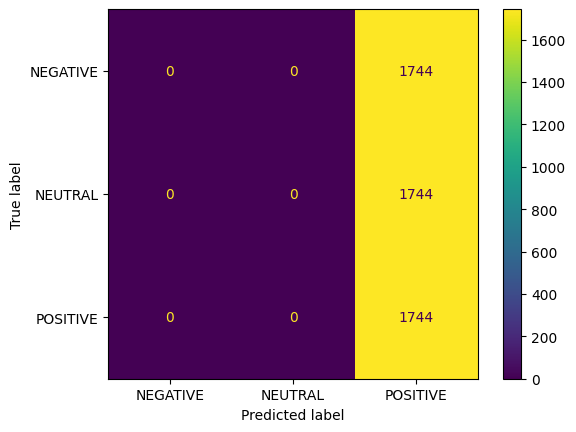

In [34]:
ConfusionMatrix(model2, best_lr2, best_eps2, best_epoch2)

Training Loss: 1.1087605414183244
Validation Loss: 1.098666572716178
Training Loss: 1.1074782609939575
Validation Loss: 1.0989098665190906
Training Loss: 1.1088806304127672
Validation Loss: 1.0986217681954547
Training Loss: 1.1065748250640637
Validation Loss: 1.0986344312749259
Training Loss: 1.1078080263437402
Validation Loss: 1.0986939683193113
Training Loss: 1.107615865647706
Validation Loss: 1.098748315398286
Training Loss: 1.10848805568462
Validation Loss: 1.098640840228011
Training Loss: 1.106497998971606
Validation Loss: 1.098638076607774
Training Loss: 1.106708819836118
Validation Loss: 1.0986816134394668
Training Loss: 1.1065571545513437
Validation Loss: 1.0986882673531044


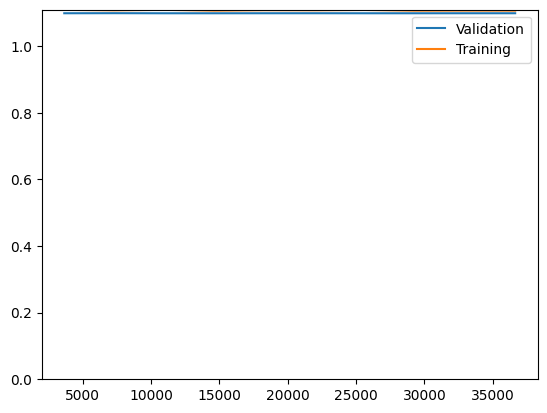

In [35]:
plot_learning_curves(model=model2, 
                     tokenizer=tokenizer2, 
                     train_set=train_dataset, 
                     val_set=val_dataset, 
                     device=device,  
                     lr=best_lr2, 
                     eps=best_eps2,
                     clip=1)

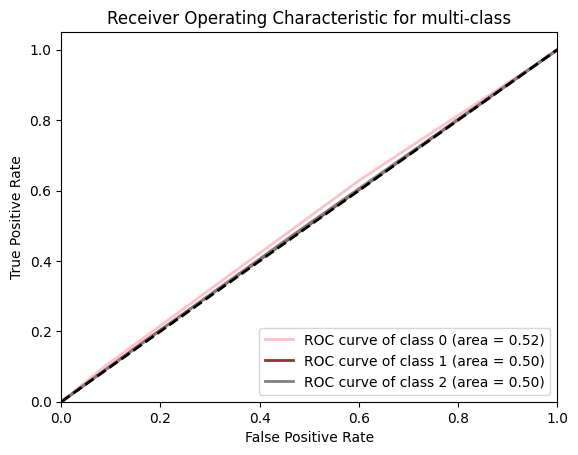

In [36]:
plot_roc_curves(model2, validation_dataloader, device, num_classes=3)